# Data source

- 데이터
    - https://www.kaggle.com/datasets/sahilnbajaj/classified-data-for-knn/data

In [2]:
# 캐글에서 데이터 다운로드
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sahilnbajaj/classified-data-for-knn")

print("Path to dataset files:", path)

100%|██████████| 89.3k/89.3k [00:00<00:00, 40.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sahilnbajaj/classified-data-for-knn/versions/1


In [20]:
!ls {path}

'Classified Data'


In [21]:
file_path = path+"/Classified Data"

In [22]:
# 라이브러리
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv(file_path, index_col=0 )
df

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1
...,...,...,...,...,...,...,...,...,...,...,...
995,1.010953,1.034006,0.853116,0.622460,1.036610,0.586240,0.746811,0.319752,1.117340,1.348517,1
996,0.575529,0.955786,0.941835,0.792882,1.414277,1.269540,1.055928,0.713193,0.958684,1.663489,0
997,1.135470,0.982462,0.781905,0.916738,0.901031,0.884738,0.386802,0.389584,0.919191,1.385504,1
998,1.084894,0.861769,0.407158,0.665696,1.608612,0.943859,0.855806,1.061338,1.277456,1.188063,1


# 데이터 표준화
- 진행하지 않음

- why?
    - 분할 기준:
        - 결정 트리는 각 특성(feature)의 값의 크기나 단위에 의존하지 않고, 데이터의 값을 기준으로 분할(예: 임계값 기준)하기 때문에 스케일이 다르더라도 분할 로직에는 영향을 주지 않음.

    - 거리 기반 아님:
        - KNN, SVM, 선형 회귀 등과 달리, 결정 트리는 거리나 기울기에 기반하지 않음. 따라서 특성 간의 상대적 크기가 모델 성능에 영향을 미치지 않음.

# 데이터 분리 (train_test_split)
- X, y 분리
- train, test set 분리

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET CLASS', axis=1), df['TARGET CLASS'],
                                                            random_state = 42,
                                                            test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 10), (200, 10), (800,), (200,))

# 모델 선택/학습/평가

In [60]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(random_state=2025)

model_tree.fit(X_train, y_train)

pred = model_tree.predict(X_test)

print("학습 점수:", model_tree.score(X_train, y_train))
print("일반화 점수:", model_tree.score(X_test, y_test))

학습 점수: 1.0
일반화 점수: 0.87


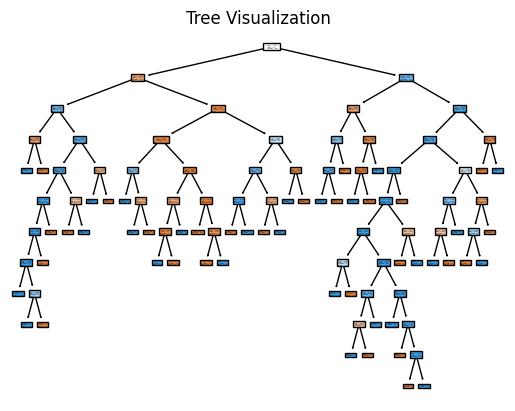

최대깊이:  11
leaf node 수:  52


In [42]:
# 시각화
from sklearn.tree import plot_tree

plot_tree(model_tree,
            filled=True)
plt.title("Tree Visualization")
plt.show()

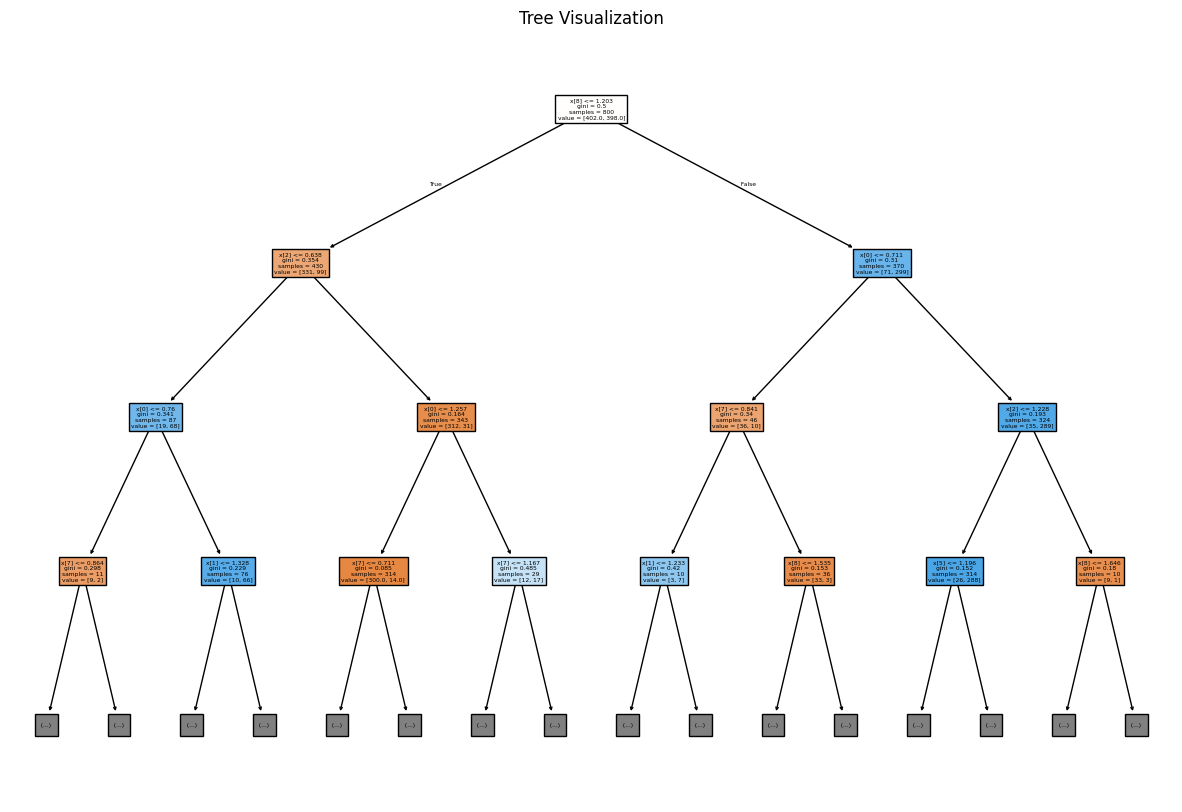

최대깊이:  11
leaf node 수:  52


In [49]:
plt.figure(figsize=(15,10))
plot_tree(model_tree,
            max_depth = 3,
            filled=True)
plt.title("Tree Visualization")
plt.show()

print("최대깊이: ", model_tree.get_depth())
print("leaf node 수: ", model_tree.get_n_leaves())

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

matrix = confusion_matrix(y_test, pred)
print("ℹ️ 혼동행렬\n", matrix)

matrix = pd.DataFrame(matrix,
                                index = [f'실제 {name}' for name in df['TARGET CLASS'].unique()],
                                columns = [f'예측 {name}' for name in df['TARGET CLASS'].unique()])

print("\n\nℹ️ df로 변환")
display(matrix)

print("\n\nℹ️ 분류 보고서")
print(classification_report(y_test, pred))


ℹ️ 혼동행렬
 [[86 12]
 [15 87]]


ℹ️ df로 변환


,예측 1,예측 0
실제 1,86,12
실제 0,15,87




ℹ️ 분류 보고서
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        98
           1       0.88      0.85      0.87       102

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



## 하이퍼파라미터 튜닝 및 교차검증

- tree의 하이퍼파라미터(과적합 방지)
    - max_depth: 2, 5, 7, 10
    - min_samples_split: 20
    - min_samples_leaf: 5, 10, 20
    - max_leaf_nodes: 30, 40, 50


In [57]:
from sklearn.model_selection import RandomizedSearchCV

model = DecisionTreeClassifier(random_state=2025)

params = { 'max_depth': [2, 5, 7, 10],
               'min_samples_split': [20],
               'min_samples_leaf': [5, 10, 20],
               'max_leaf_nodes': [30, 40, 50]}

random_search = RandomizedSearchCV(estimator = model_tree,
                                                    param_distributions=params,
                                                    n_iter = 36,                        # 각 파라미터 옵션 수를 곱한 값 : 하이퍼파라미터 조합 수
                                                    cv = 5,
                                                    random_state=2025,
                                                    n_jobs=-1,
                                                    verbose=2)

random_search.fit(X_train, y_train)

print("\n최적 하이퍼파라미터:", random_search.best_params_)
print("최고 교차 검증 점수:", random_search.best_score_)

best_model_random = random_search.best_estimator_

print("\n최적 모델 학습 점수:", best_model_random.score(X_train, y_train))
print("최적 모델 일반화 점수:", best_model_random.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

최적 하이퍼파라미터: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_leaf_nodes': 30, 'max_depth': 5}
최고 교차 검증 점수: 0.86625

최적 모델 학습 점수: 0.93875
최적 모델 일반화 점수: 0.905


In [63]:
print("- 기본 모델")
print("학습 점수:", model_tree.score(X_train, y_train))
print("일반화 점수:", model_tree.score(X_test, y_test))

print("\n- 하이퍼파라미터 튜닝 모델")
print("학습 점수:", best_model_random.score(X_train, y_train))
print("일반화 점수:", best_model_random.score(X_test, y_test))

- 기본 모델
학습 점수: 1.0
일반화 점수: 0.87

- 하이퍼파라미터 튜닝 모델
학습 점수: 0.93875
일반화 점수: 0.905


일반화 성능 향상: 0.87 -> 0.905

## 최종 성능 평가

In [64]:
pred = best_model_random.predict(X_test)
matrix = confusion_matrix(y_test, pred)
print("ℹ️ 혼동행렬\n", matrix)

matrix = pd.DataFrame(matrix,
                                index = [f'실제 {name}' for name in df['TARGET CLASS'].unique()],
                                columns = [f'예측 {name}' for name in df['TARGET CLASS'].unique()])

print("\n\nℹ️ df로 변환")
display(matrix)

print("\n\nℹ️ 분류 보고서")
print(classification_report(y_test, pred))

ℹ️ 혼동행렬
 [[92  6]
 [13 89]]


ℹ️ df로 변환


,예측 1,예측 0
실제 1,92,6
실제 0,13,89




ℹ️ 분류 보고서
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        98
           1       0.94      0.87      0.90       102

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200

